In [1]:
!source ~/.zshrc

In [73]:
import os
from sodapy import Socrata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rtree
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely import wkt
from zipfile import ZipFile
import glob
from datetime import datetime, date


# Establish SodaPy connection
# Establish env variables
username = os.getenv('soc_user')
password = os.getenv('soc_pass')
token = os.getenv('soc_app_token')

# Authenticate client (needed for non-public datasets):
client = Socrata("data.cityofchicago.org", 
                 token, 
                 username=username, 
                 password=password,
                timeout=25)


In [3]:
# Read in neighborhoods
chicago = gpd.read_file("data/Boundaries - Community Areas (current)", crs = {'init': 'epsg:4326'})

# Pull Divvy station through socrata API
station_data = client.get('bk89-9dk7')


In [4]:
# Create Pandas DF to fix long & lat
divvy_data = pd.DataFrame(station_data)

divvy_data['longitude'] = divvy_data['longitude'].apply(lambda x: float(x))
divvy_data['latitude'] = divvy_data['latitude'].apply(lambda x: float(x))

In [19]:
# Create Divvy Station data GeoDataFrame
all_divvy_stations = gpd.GeoDataFrame(divvy_data, 
                                      geometry = gpd.points_from_xy(divvy_data['longitude'], divvy_data['latitude']))

# Rename columns
all_divvy_stations.rename(columns={':@computed_region_awaf_s7ux':'Historical Wards 2003-2015',
                              ':@computed_region_6mkv_f3dw':'Zip Codes',
                              ':@computed_region_vrxf_vc4k':'Community Areas',
                              ':@computed_region_bdys_3d7i':'Census Tracts',
                              ':@computed_region_43wa_7qmu':'Wards'},
                     inplace=True)

all_divvy_stations = all_divvy_stations.drop(['Zip Codes', 'location'], axis=1)

#Align CRS types
chicago.crs={'init':'epsg:4326'}
all_divvy_stations.crs = {'init':'epsg:4326'}

#Print Info
all_divvy_stations.info()
print("\n\n")
chicago.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   station_name                595 non-null    object  
 1   Wards                       581 non-null    object  
 2   total_docks                 595 non-null    object  
 3   latitude                    595 non-null    float64 
 4   Historical Wards 2003-2015  581 non-null    object  
 5   longitude                   595 non-null    float64 
 6   Census Tracts               581 non-null    object  
 7   status                      595 non-null    object  
 8   Community Areas             581 non-null    object  
 9   docks_in_service            595 non-null    object  
 10  id                          595 non-null    object  
 11  geometry                    595 non-null    geometry
dtypes: float64(2), geometry(1), object(9)
memory usage: 55.9+ KB



<class

In [28]:
#Fix Data Types
divvy_stations = all_divvy_stations[all_divvy_stations['Wards'].isna()==False]
divvy_stations = divvy_stations.drop(['Census Tracts', 'Historical Wards 2003-2015'], axis=1)
divvy_stations['total_docks'] = divvy_stations['total_docks'].apply(lambda x: int(x))
divvy_stations['docks_in_service'] = divvy_stations['docks_in_service'].apply(lambda x: int(x))

#Align CRS types
chicago.crs={'init':'epsg:4326'}



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [29]:
# Define Function to Assign Groups

def assign_sides(ward):
    if ward in far_north_side:
        return "far north side"
    elif ward in northwest_side:
        return "northwest side"
    elif ward in north_side:
        return "north side"
    elif ward in west_side:
        return "west side"
    elif ward in central:
        return "loop"
    elif ward in south_side:
        return "south side"
    elif ward in southwest_side:
        return "southwest side"
    elif ward in far_southwest_side:
        return "far southwest side"
    elif ward in far_south_side:
        return "far south side"
    else:
        return "None"

In [30]:
def find_polygon(coordinate):
    dex =  chicago[chicago['geometry'].contains(coordinate)].index.values[0]
    return chicago['area_num_1'][dex]
    

In [31]:
# Define Chicago Side Groups
far_north_side = ['76', '9', '10', '11', '12', '13', '14', '4', '2', '3', '77', '1']
northwest_side = ['17', '18', '19', '20', '15', '16']
north_side = ['22', '21', '5', '6', '7']
west_side = ['25', '26', '27', '23', '24', '28', '29', '31', '30']
central = ['33', '32', '8']
south_side = ['60', '37', '34', '35', '36', '40', '41', '42', '69', '43', '38', '39']
southwest_side = ['56', '64', '65', '66', '67', '68', '62', '63', '61', '57', '58', '59']
far_southwest_side = ['74', '75', '72', '73', '71', '70']
far_south_side = ['55', '54', '51', '49', '53', '50', '44', '47', '45', '46', '48', '46', '52']


# All Wards List
#all_wards = far_north_side + northwest_side + north_side + west_side + central + south_side + far_southwest_side + southwest_side + far_south_side


In [33]:
#Fix Coimmunity Area Data
divvy_stations['fix_area'] = divvy_stations.geometry.apply(lambda x: find_polygon(x))

# Assign Groups
chicago['side'] = chicago['area_num_1'].apply(lambda x: assign_sides(x))
divvy_stations['side'] = divvy_stations['fix_area'].apply(lambda x: assign_sides(x))


# Drop Areas not in City
chicago = chicago[chicago['side']!='None']
divvy_stations

,station_name,Wards,total_docks,latitude,longitude,status,Community Areas,docks_in_service,id,geometry,fix_area,side
0,Clinton St & Polk St,26,15,41.871467,-87.640949,In Service,29,15,103,POINT (-87.64095 41.87147),28,west side
1,Jeffery Blvd & 71st St,33,11,41.766638,-87.576450,In Service,39,11,11,POINT (-87.57645 41.76664),43,south side
2,South Shore Dr & 71st St,33,15,41.766409,-87.565688,In Service,39,15,12,POINT (-87.56569 41.76641),43,south side
3,Kingsbury St & Kinzie St,36,31,41.889177,-87.638506,In Service,37,31,133,POINT (-87.63851 41.88918),8,loop
4,Peoria St & Jackson Blvd,26,19,41.877642,-87.649618,In Service,29,19,134,POINT (-87.64962 41.87764),28,west side
...,...,...,...,...,...,...,...,...,...,...,...,...
590,Halsted St & North Branch St,46,15,41.899368,-87.648480,In Service,37,15,365,POINT (-87.64848 41.89937),8,loop
591,Wood St & 35th St,1,11,41.830105,-87.670298,In Service,56,11,369,POINT (-87.67030 41.83010),59,southwest side
592,Clark St & Lake St,36,27,41.886021,-87.630876,In Service,38,27,38,POINT (-87.63088 41.88602),32,loop
593,Calumet Ave & 51st St,9,11,41.802295,-87.618054,In Service,4,11,415,POINT (-87.61805 41.80229),38,south side


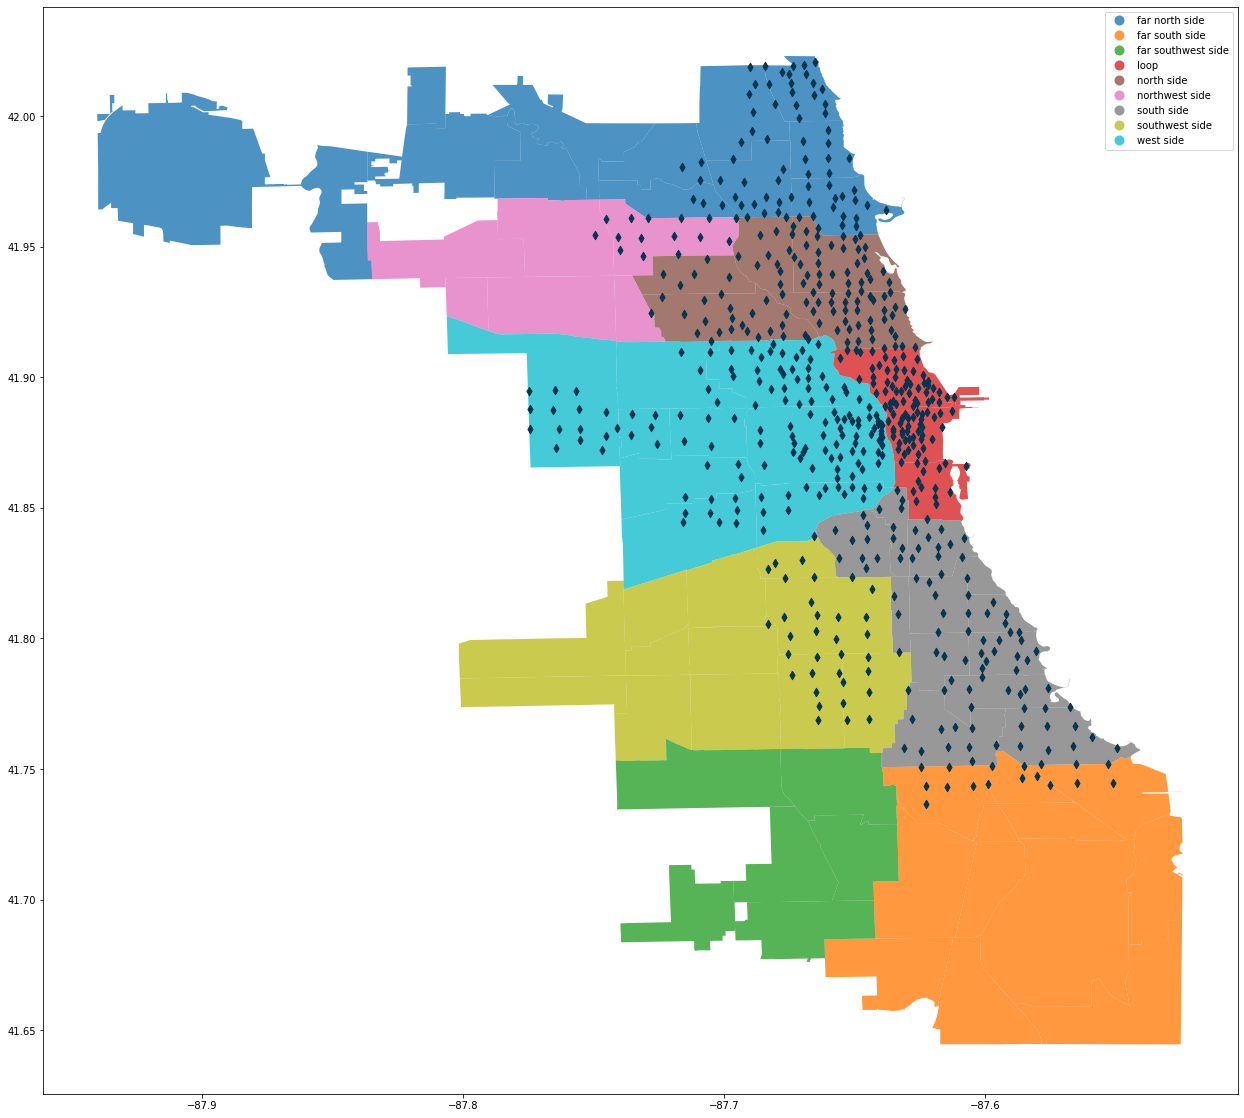

In [34]:
base = chicago.plot(figsize=(30,20), alpha=0.8, column='side', legend = True)

divvy_stations.plot(ax=base, figsize=(30,20), marker ='d', color='#063550')

In [35]:
divvy_stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 581 entries, 0 to 594
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   station_name      581 non-null    object  
 1   Wards             581 non-null    object  
 2   total_docks       581 non-null    int64   
 3   latitude          581 non-null    float64 
 4   longitude         581 non-null    float64 
 5   status            581 non-null    object  
 6   Community Areas   581 non-null    object  
 7   docks_in_service  581 non-null    int64   
 8   id                581 non-null    object  
 9   geometry          581 non-null    geometry
 10  fix_area          581 non-null    object  
 11  side              581 non-null    object  
dtypes: float64(2), geometry(1), int64(2), object(7)
memory usage: 59.0+ KB


In [36]:
# High Level Analysis on Divvy stations by general area of Chicago
station_agg = divvy_stations.groupby(['side']).agg({'id':'count', 
                                                'total_docks':'sum',
                                                'docks_in_service':'sum'})
station_agg.sort_values('id', ascending=False)

,id,total_docks,docks_in_service
side,,,
west side,143,2381,2372
north side,109,1967,1967
loop,105,2651,2651
south side,93,1275,1275
far north side,69,1127,1127
southwest side,33,351,351
far south side,15,161,161
northwest side,14,194,194


In [59]:
# Establish zips
q2_zip = ZipFile('data/divvy trips/Divvy_Trips_2018_Q2.zip', 'r')
q3_zip = ZipFile('data/divvy trips/Divvy_Trips_2018_Q3.zip', 'r')
q4_zip = ZipFile('data/divvy trips/Divvy_Trips_2018_Q4.zip', 'r')


# Read in Trip Data
q2 = q2_zip.open('Divvy_Trips_2018_Q2.csv')
q3 = q3_zip.open('Divvy_Trips_2018_Q3.csv')
q4 = q4_zip.open('Divvy_Trips_2018_Q4.csv')

# Create DF
q2_trips = pd.read_csv(q2)
q3_trips = pd.read_csv(q3)
q4_trips = pd.read_csv(q4)



In [64]:
group_trips = [q2_trips, q3_trips, q4_trips]
trips_df = pd.concat(group_trips, ignore_index=True)
trips_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3215937 entries, 0 to 3215936
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   trip_id            int64  
 1   start_time         object 
 2   end_time           object 
 3   bikeid             int64  
 4   tripduration       object 
 5   from_station_id    int64  
 6   from_station_name  object 
 7   to_station_id      int64  
 8   to_station_name    object 
 9   usertype           object 
 10  gender             object 
 11  birthyear          float64
dtypes: float64(1), int64(4), object(7)
memory usage: 294.4+ MB


In [78]:
# Add Calculations and fix datetimes
#trips_df['tripduration'] = trips_df['tripduration'].apply(lambda x: round(float(x.replace(",","")),2))
trips_df['trip duration (min)'] = trips_df['tripduration']/60
trips_df['start_time'] = trips_df['start_time'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
trips_df['end_time'] = trips_df['end_time'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
trips_df['month'] = trips_df['start_time'].apply(lambda x: x.strftime('%b-%y'))

In [91]:
# Define Station Look Up Functions
def station_comm_num(id):
    dex = divvy_stations[divvy_stations['id']==id].index
    y = divvy_stations.loc[dex]['fix_area'].values
    num = str(y).replace("['","").replace("']", "")
    return num

def station_side(id):
    dex = divvy_stations[divvy_stations['id']==id].index
    y = divvy_stations.loc[dex]['side'].values
    side = str(y).replace("['","").replace("']", "")
    return side

In [ ]:
trips_df['from comm num'] = trips_df['from_station_id'].apply(lambda x: station_comm_num(x))
trips_df['to comm num'] = trips_df['to_station_id'].apply(lambda x: station_comm_num(x))
trips_df['from side'] = trips_df['from_station_id'].apply(lambda x: station_side(x))
trips_df['to side'] = trips_df['to_station_id'].apply(lambda x: station_side(x))

In [ ]:
# General Aggregates
from_agg_by_side = trips_df.groupby('from side').agg('count')